In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [2]:
def build_post_struct(lines):
    slug = next(line[len('slug:'):].strip() for line in lines[:10] if line.lower().startswith('slug:'))
    return {'slug': slug, 'contents': '\n'.join(lines[10:]).lower()}

BLOG_DIR = "d:/code/blog/content"
paths = [f'{BLOG_DIR}/{f}' for f in os.listdir(BLOG_DIR) if f.lower().endswith(".md")]
posts = [build_post_struct(open(path, encoding="utf8").read().splitlines()) for path in paths]
tagged_posts = {post['slug'] : TaggedDocument(word_tokenize(post['contents']), [idx]) for idx, post in enumerate(posts)}
idx_lookup = {idx : post['slug'] for idx, post in enumerate(posts)}
model = Doc2Vec(tagged_posts.values(), vector_size=100, alpha=0.025, min_count=1, workers=16, epochs=100)

In [3]:
def similar_posts(which, n=3):
    if not isinstance(which, str):
        which = idx_lookup[which]
    # at this point which is the slug
    if n == 'all':
        return model.dv.most_similar(positive=[model.infer_vector(tagged_posts[which][0])], topn=None)
    results = model.dv.most_similar(positive=[model.infer_vector(tagged_posts[which][0])], topn=n+1)
    results = [(idx_lookup[idx], score) for idx, score in results if idx != tagged_posts[which][1][0]]
    return results[:n]

In [4]:
similar_posts('investigating-information-storage-in-quantized-autoencoders-with-pytorch-and-mnist')

[('classification-accuracy-of-quantized-autoencoders-with-pytorch-and-mnist',
  0.8650367856025696),
 ('building-a-pytorch-autoencoder-for-mnist-digits', 0.6518847346305847),
 ('automatic-mlflow-logging-for-pytorch', 0.603656530380249)]

In [5]:
similar_posts('python-decorator-patterns')

[('python-decorators-for-data-scientists', 0.7099549174308777),
 ('building-a-toy-python-dataclass-decorator', 0.6292378306388855),
 ('building-a-simple-python-enum-class', 0.5797753930091858)]

In [6]:
similar_posts('five-ways-to-reduce-variance-in-ab-testing')

[('ab-testing-and-the-historic-lift-paradox', 0.5735045671463013),
 ('correlations-seasonality-lift-and-cuped', 0.5411384701728821),
 ('reducing-variance-in-ab-testing-with-cuped', 0.5386991500854492)]

In [7]:
def plot_matrix(m):
    plt.imshow(m, cmap='YlOrRd', interpolation='nearest')
    plt.colorbar()
    plt.show()

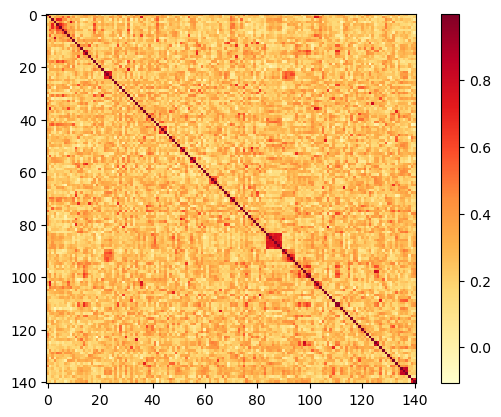

In [8]:
similarity_matrix = [similar_posts(idx, n='all') for idx in idx_lookup.keys()]
plot_matrix(similarity_matrix)

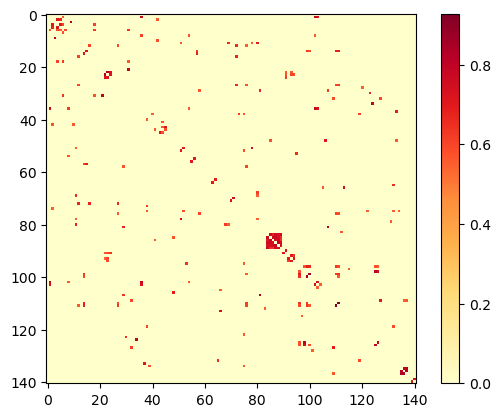

In [9]:
similarity_matrix_truncated = [[y if y > 0.55 else 0 for y in x] for x in similarity_matrix]
for i in range(len(similarity_matrix_truncated)):
    similarity_matrix_truncated[i][i] = 0
plot_matrix(similarity_matrix_truncated)

In [10]:
def plot_graph(m):
    labels = list(range(len(m)))
    df = pd.DataFrame(m, index=labels, columns=labels)
    G = nx.from_pandas_adjacency(df)
    plt.figure(figsize=(15, 15))
    nx.draw_networkx(G, nx.spring_layout(G), node_size=0, arrows=False, edge_color='lightgray', font_size=8)
    plt.show()

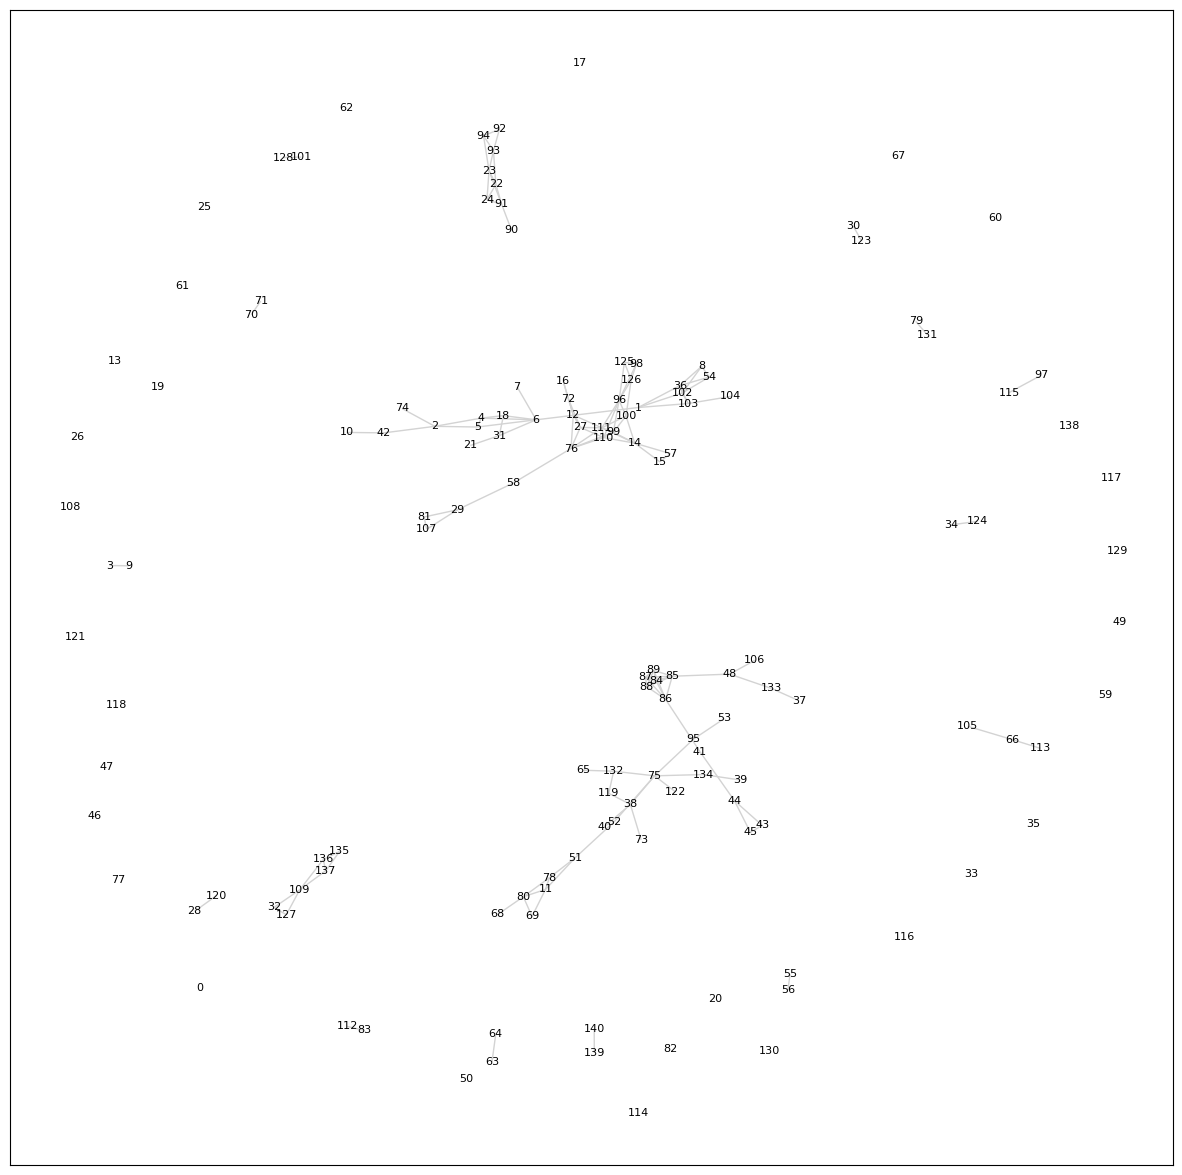

In [11]:
plot_graph(similarity_matrix_truncated)

In [12]:
print([
        [idx_lookup[63], idx_lookup[64]],
        [idx_lookup[3], idx_lookup[9]],
        [idx_lookup[37], idx_lookup[47], idx_lookup[48], idx_lookup[106], idx_lookup[133]],
])

[['how-good-a-data-scientist-is-gpt-3', 'how-good-a-particle-physicist-is-gpt-3'], ['ab-testing-and-network-effects', 'ab-testing-on-social-networks'], ['cross-entropy-joint-entropy-conditional-entropy-and-relative-entropy', 'entropy-in-data-science', 'entropy-of-an-ideal-gas-with-coarse-graining', 'the-physical-sackur-tetrode-entropy-of-an-ideal-gas', 'what-is-the-entropy-of-a-fair-coin-toss']]


In [13]:
def clusters(m):
    connected_subgraphs = set([frozenset([i]) for i in list(range(len(m)))])
    def update_subgraphs(i, j):
        join_targets = [g for g in connected_subgraphs if i in g or j in g]
        new_subgraph = frozenset({i for g in join_targets for i in g})
        for g in join_targets:
            connected_subgraphs.remove(g)
        connected_subgraphs.add(new_subgraph)
    for i in range(len(m)):
        for j in range(len(m)):
            if m[i][j] > 0:
                update_subgraphs(i, j)
    return connected_subgraphs

def print_clusters(connected_subgraphs):
    for g in connected_subgraphs:
        if len(g) == 1:
            for i in g:
                print(f'Singleton: {idx_lookup[i]}')
    for g in connected_subgraphs:
        if len(g) > 1:
            print('Cluster:')
            for i in g:
                print({idx_lookup[i]})

In [14]:
c = clusters(similarity_matrix_truncated)
print_clusters(c)

Singleton: how-good-a-data-scientist-is-gpt-3-part-ii
Singleton: understanding-facebook-planout-ab-testing-framework
Singleton: systems-thinking
Singleton: small-team-planning
Singleton: more-data-scientists-should-learn-sql
Singleton: comparing-conversion-at-control-and-treatment-sites
Singleton: the-elements-of-typographic-style
Singleton: hbr-guide-to-better-business-writing
Singleton: backtraced-growth-accounting
Singleton: the-best-parts-of-jeff-bezos-invent-and-wander
Singleton: entropy-in-data-science
Singleton: the-collatz-conjecture
Singleton: einsteins-amazing-theory
Singleton: hack-hhvm-second-system-effect
Singleton: validation-checks-for-ab-tests
Singleton: estimating-famous-mathematical-constants-with-monte-carlo-simulations
Singleton: 100-articles
Singleton: building-intuition-p-values-statistical-significance
Singleton: ten-ways-to-iterate-from-0-to-1-with-deciles
Singleton: working-backwards
Singleton: warehouse-locations-with-kmeans
Singleton: porsche-70
Singleton: as

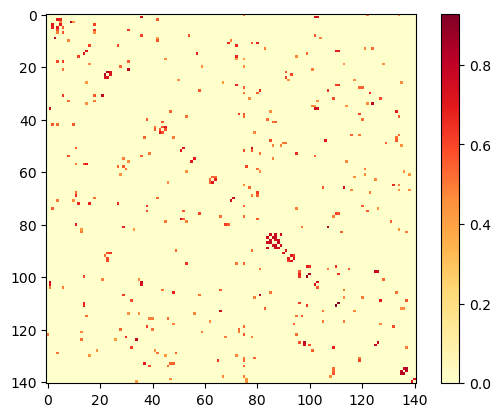

In [15]:
# another approach, to avoid singletons:
# for each post, get the top n=3 most similar
def similarity_matrix_top_n(n=3):
    m = [[0 for _ in range(len(posts))] for _ in range(len(posts))]
    for i in list(range(len(m))):
        sp = similar_posts(i, n)
        idxs = [tagged_posts[p[0]][1][0] for p in sp]
        for k, j in enumerate(idxs):
            m[i][j] = sp[k][1]
    return m

similarity_matrix_truncated = similarity_matrix_top_n(n=3)
plot_matrix(similarity_matrix_truncated)

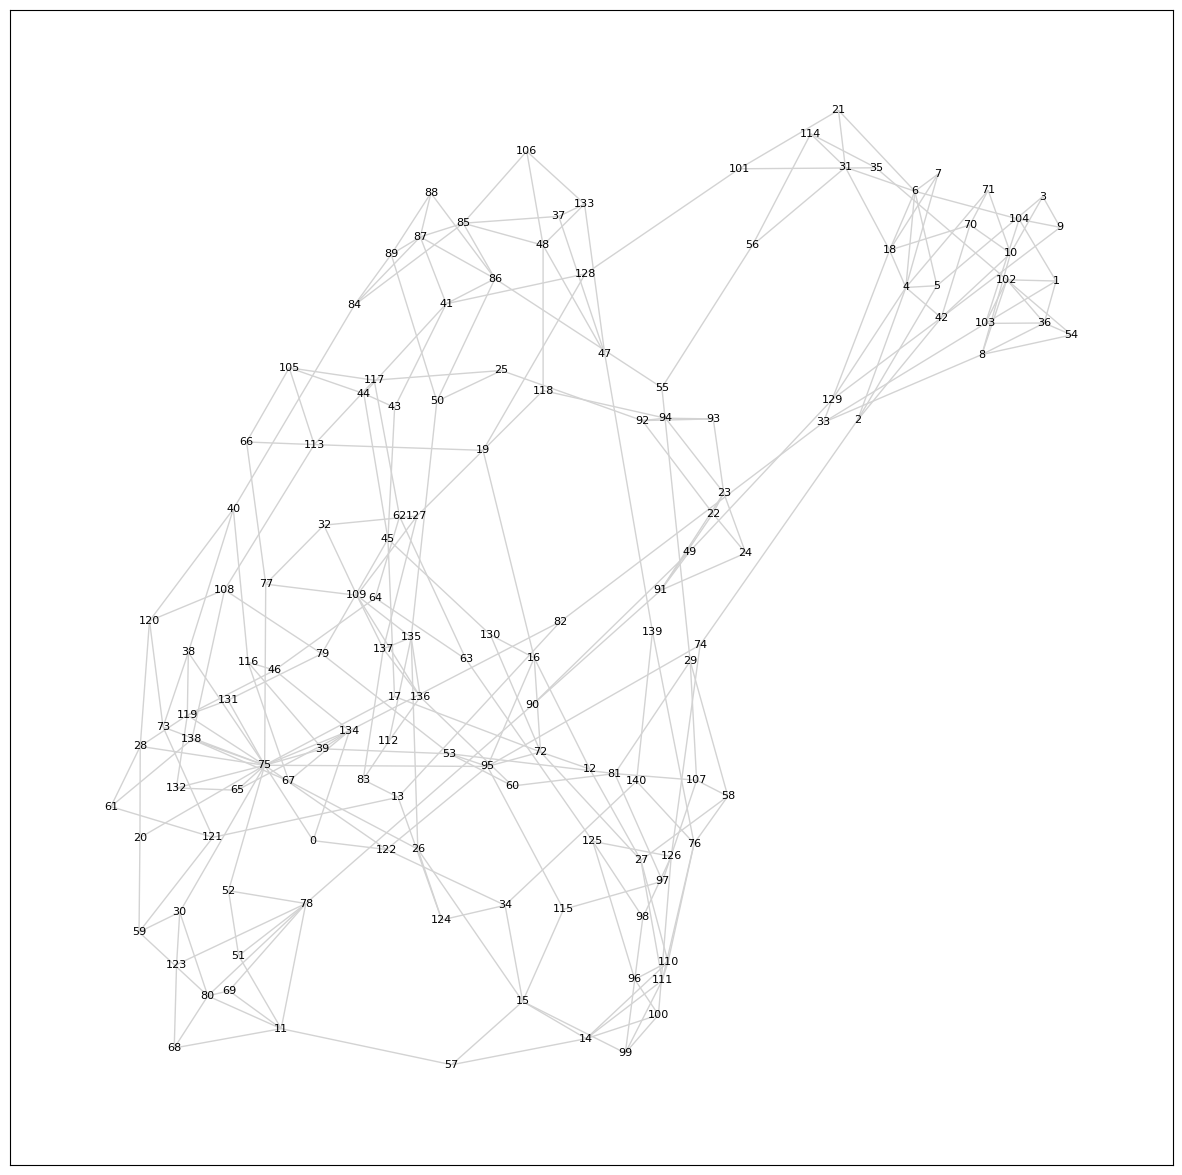

In [16]:
plot_graph(similarity_matrix_truncated)

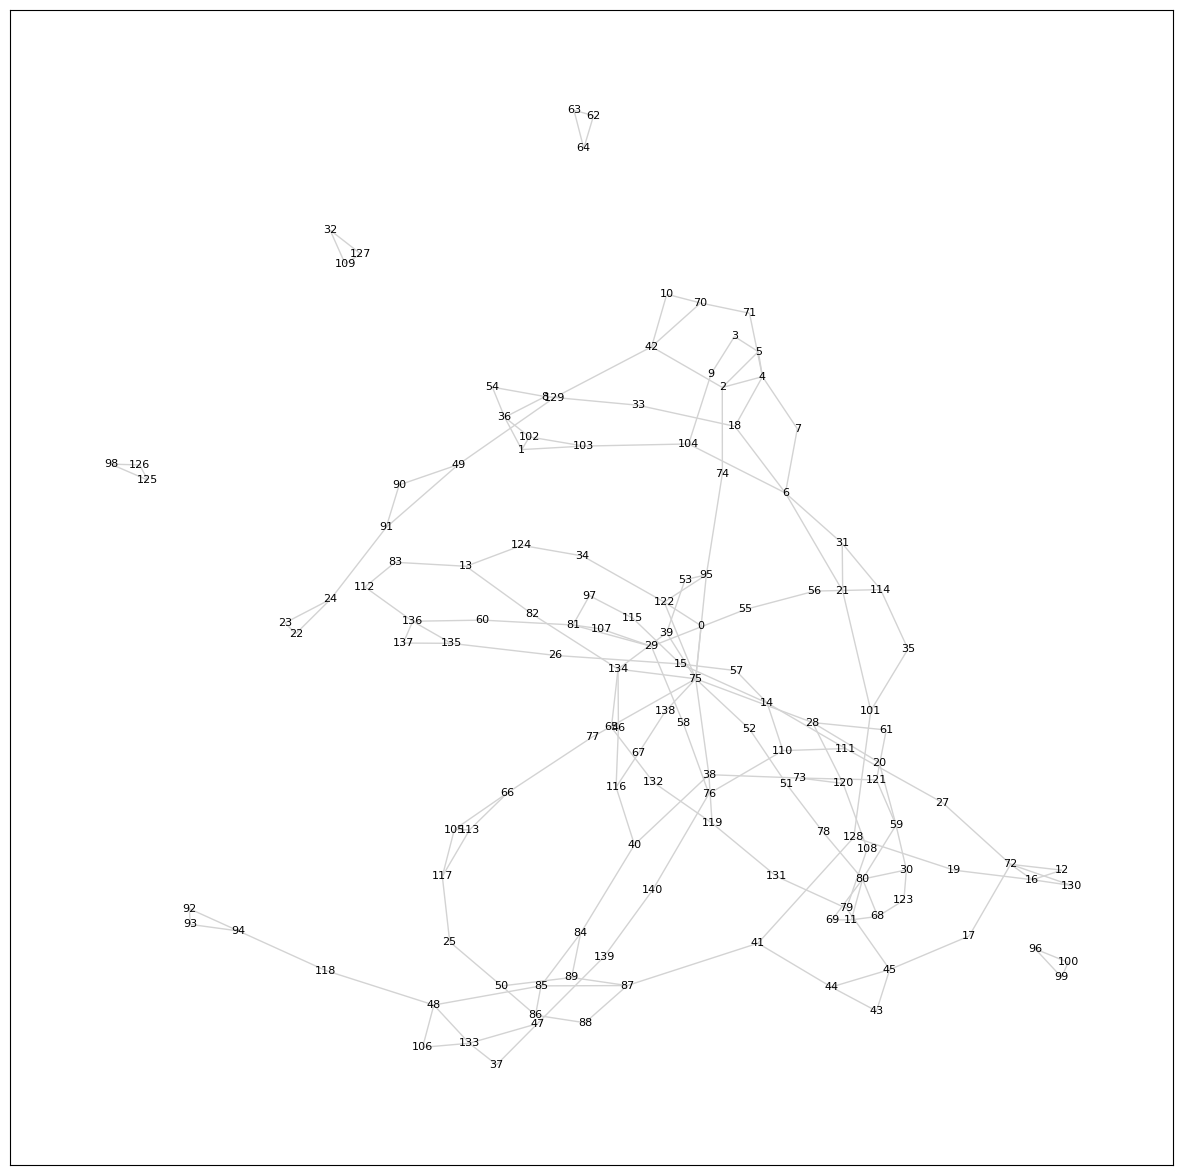

In [17]:
similarity_matrix_truncated = similarity_matrix_top_n(n=2)
plot_graph(similarity_matrix_truncated)

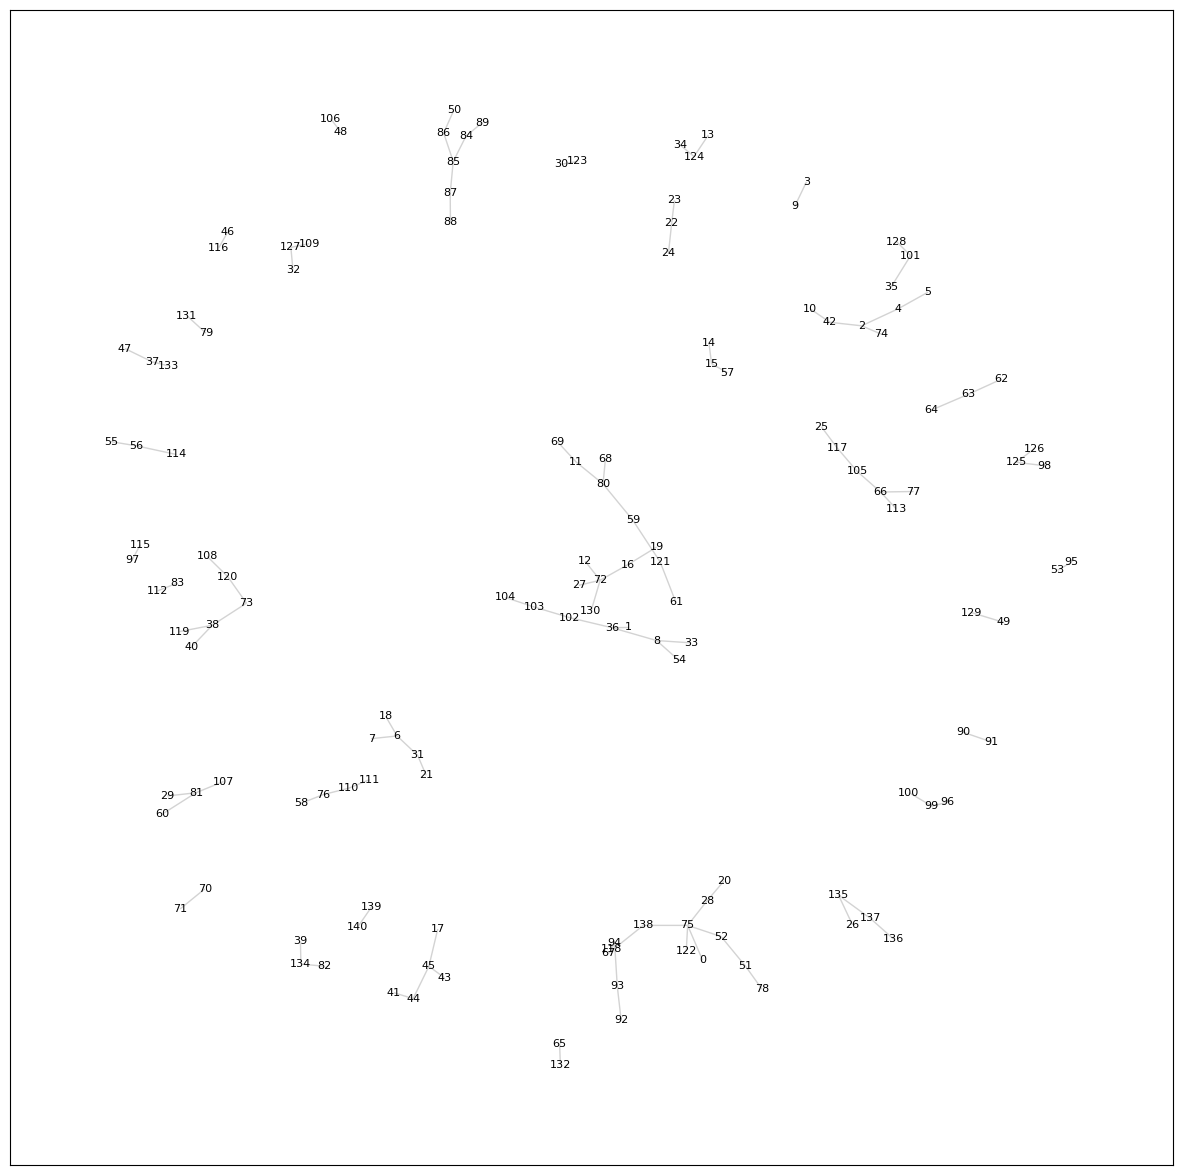

In [18]:
similarity_matrix_truncated = similarity_matrix_top_n(n=1)
plot_graph(similarity_matrix_truncated)

In [19]:
c = clusters(similarity_matrix_truncated)
print_clusters(c)

Cluster:
{'culture-docs-facebook-netflix-and-valve'}
{'the-company-is-all-hot-air'}
{'delightfully-cynical-half-truths-about-organizations'}
{'data-science-culture-doc'}
{'small-team-planning'}
{'the-culture-map'}
Cluster:
{'cross-entropy-joint-entropy-conditional-entropy-and-relative-entropy'}
{'what-is-the-entropy-of-a-fair-coin-toss'}
{'entropy-in-data-science'}
Cluster:
{'sql-best-practices-for-data-scientists-and-analysts'}
{'how-i-write-sql-code'}
{'ten-ways-to-iterate-from-0-to-1-with-deciles'}
{'rxe-literate-and-composable-regular-expressions'}
{'more-data-scientists-should-learn-sql'}
{'building-intuition-p-values-statistical-significance'}
Cluster:
{'how-i-manage-notifications-to-keep-myself-uninterrupted'}
{'wetoddle-retrospective'}
Cluster:
{'building-a-toy-python-dataclass-decorator'}
{'building-a-simple-python-enum-class-part-ii'}
{'building-a-simple-python-enum-class'}
Cluster:
{'how-to-make-a-blog-like-this'}
{'cloud9'}
Cluster:
{'building-a-pytorch-autoencoder-for-mnis